## Model Assessment

In [115]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [116]:
RANDOM_STATE = 42

In [117]:
def load_and_preprocess(filepath: str) -> pd.DataFrame:
    churn_df = pd.read_csv(filepath)
    # Drop customerID
    churn_df = churn_df.drop(columns=['customerID'])
    # Convert TotalCharges to numeric and drop missing values
    churn_df['TotalCharges'] = pd.to_numeric(churn_df['TotalCharges'], errors='coerce')
    churn_df = churn_df.dropna(subset=['TotalCharges'])

    # Encode binary features
    binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
    for col in binary_cols:
        churn_df[col] = churn_df[col].map({'Yes': 1, 'No': 0})
    # Map gender
    churn_df['gender'] = churn_df['gender'].map({'Male': 1, 'Female': 0})

    # One-hot encode remaining categorical variables
    categorical_cols = churn_df.select_dtypes(include=['object']).columns.tolist()
    churn_df = pd.get_dummies(churn_df, columns=categorical_cols, drop_first=True)

    # Scale numeric features
    numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
    scaler = StandardScaler()
    churn_df[numeric_cols] = scaler.fit_transform(churn_df[numeric_cols])

    return churn_df

In [118]:
def evaluate_model(trained_models_object, train_set, test_set, train_target, test_target) -> dict:
    trained_models_object.fit(train_set, train_target)
    y_pred = trained_models_object.predict(test_set)
    # Get probabilities or decision function for ROC AUC
    if hasattr(trained_models_object, 'predict_proba'):
        y_score = trained_models_object.predict_proba(test_set)[:, 1]
    elif hasattr(trained_models_object, 'decision_function'):
        y_score = trained_models_object.decision_function(test_set)
    else:
        y_score = None

    return {
        'accuracy': accuracy_score(test_target, y_pred),
        'precision': precision_score(test_target, y_pred),
        'recall': recall_score(test_target, y_pred),
        'f1_score': f1_score(test_target, y_pred),
        'roc_auc': roc_auc_score(test_target, y_score) if y_score is not None else float('nan'),
    }

In [119]:
def plot_roc_curves(models_dict, X_test, y_test, title='ROC Curves'):
    """
    Plots ROC curves for multiple classifiers.

    Parameters:
    - models_dict: dict of {name: trained_model}
    - X_test: test features
    - y_test: true labels for test set
    - title: title for the ROC plot
    """
    plt.figure(figsize=(8, 6))
    ypp = None
    for n, m in models_dict.items():
        if hasattr(m, "predict_proba"):
            ypp = m.predict_proba(X_test)[:, 1]
        elif hasattr(m, "decision_function"):
            ypp = m.decision_function(X_test)
        else:
            print(f"Model {n} does not support probability prediction. ignoring it.")
            continue

        fpr, tpr, _ = roc_curve(y_test, ypp)
        auc_score = roc_auc_score(y_test, ypp)
        plt.plot(fpr, tpr, label=f'{n} (AUC = {auc_score:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [120]:
df = load_and_preprocess('../data/Telco-Customer-Churn.csv')

In [121]:
y = df['Churn']
X = df.drop(columns=['Churn'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)


In [122]:
n_estimators = [50, 100, 200, 300, 400, 500]
learning_rates = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
param_grids = {
    'Logistic Regression': {'C': [0.01, 0.02, 0.05, 0.1, 1, 5, 10]},
    'Random Forest': {'n_estimators': n_estimators, 'max_depth': [None, 5, 10, 20]},
    'Support Vector Machine': {'C': [0.01, 0.1, 0.5, 1, 10, 20], 'gamma': ['scale', 'auto']},
    'Gradient Boosting': {'n_estimators': n_estimators, 'learning_rate': learning_rates, 'max_depth': [1, 2, 3, 5]},
    'AdaBoost': {'n_estimators': n_estimators, 'learning_rate': learning_rates},
    'Decision Tree': {'max_depth': [None, 5, 10, 15]},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7, 9, 20, 30]},
}


In [123]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Support Vector Machine': SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'K-Nearest Neighbors': KNeighborsClassifier(),
}

In [124]:
results = {}
trained_models = {}
training_times = {}
overall_start = time.time()

for name, model in models.items():
    start_time = time.time()
    print(f'\nTraining {name}...')
    if name in param_grids:
        print(f'Performing GridSearchCV for {name}...')
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f'Best parameters for {name}: {grid_search.best_params_}')
    else:
        best_model = model

    end_time = time.time()
    training_time = end_time - start_time
    training_times[name] = training_time
    print(f'Training time for {name}: {training_time:.2f} seconds')
    results[name] = evaluate_model(best_model, X_train, X_test, y_train, y_test)
    trained_models[name] = best_model

overall_end = time.time()
total_training_time = overall_end - overall_start
print(f'\nTotal training time for all models: {total_training_time:.2f} seconds')


Training Logistic Regression...
Performing GridSearchCV for Logistic Regression...
Best parameters for Logistic Regression: {'C': 10}
Training time for Logistic Regression: 0.18 seconds

Training Random Forest...
Performing GridSearchCV for Random Forest...
Best parameters for Random Forest: {'max_depth': 5, 'n_estimators': 50}
Training time for Random Forest: 12.17 seconds

Training Support Vector Machine...
Performing GridSearchCV for Support Vector Machine...
Best parameters for Support Vector Machine: {'C': 0.1, 'gamma': 'auto'}
Training time for Support Vector Machine: 25.40 seconds

Training Gradient Boosting...
Performing GridSearchCV for Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 300}
Training time for Gradient Boosting: 130.82 seconds

Training AdaBoost...
Performing GridSearchCV for AdaBoost...
Best parameters for AdaBoost: {'learning_rate': 0.1, 'n_estimators': 500}
Training time for AdaBoost: 22.28 sec

In [125]:
results_df = pd.DataFrame(results).T
results_df = results_df[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]

In [126]:
results_df.to_csv('../model_performance.csv', index=True)
results_df

,accuracy,precision,recall,f1_score,roc_auc
Logistic Regression,0.788913,0.624595,0.516043,0.565154,0.831771
Random Forest,0.785359,0.662162,0.393048,0.493289,0.832036
Support Vector Machine,0.791045,0.658730,0.443850,0.530351,0.819228
Gradient Boosting,0.788202,0.641791,0.459893,0.535826,0.837637
AdaBoost,0.788913,0.671111,0.403743,0.504174,0.835202
Decision Tree,0.775409,0.575521,0.590909,0.583113,0.812966
K-Nearest Neighbors,0.788913,0.619938,0.532086,0.572662,0.822858


<Figure size 1200x600 with 0 Axes>

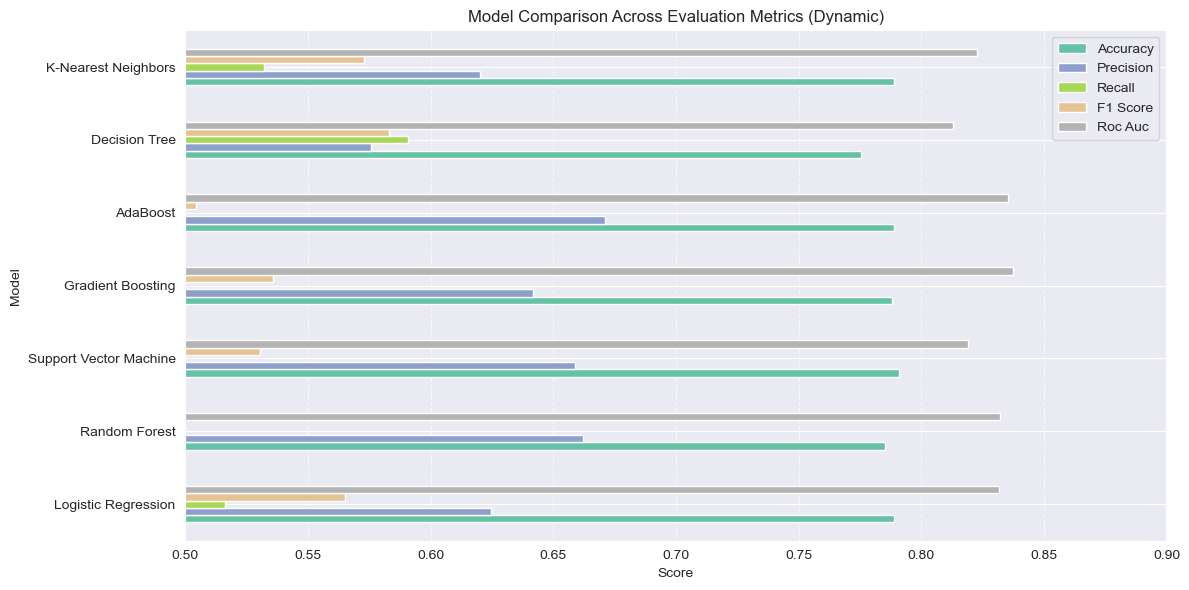

In [127]:
dynamic_df = pd.DataFrame.from_dict(results, orient='index')

dynamic_df.columns = [col.replace('_', ' ').title() for col in dynamic_df.columns]
dynamic_df.index.name = "Model"

plt.figure(figsize=(12, 6))
dynamic_df.plot(kind='barh', figsize=(12, 6), colormap='Set2')
plt.title("Model Comparison Across Evaluation Metrics (Dynamic)")
plt.xlabel("Score")
plt.xlim(0.5, 0.9)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()


### Model Evaluation Summary

We evaluated seven classification models using five metrics: accuracy, precision, recall, F1-score, and ROC AUC. The results show that Gradient Boosting and AdaBoost achieved the highest ROC AUC scores (0.835 and 0.836, respectively), indicating strong overall classification performance even under class imbalance.

Logistic Regression delivered the highest recall (0.516) and F1-score (0.565), making it a strong baseline model. Decision Tree showed the highest recall (0.591), but with a slightly lower ROC AUC, indicating a more aggressive approach to positive predictions.

While SVM and Random Forest showed competitive precision and accuracy, they had relatively lower recall. K-Nearest Neighbors performed the weakest across all metrics, making it less suitable for this task.

Overall, Gradient Boosting and AdaBoost provide the best balance between performance and reliability. Logistic Regression remains a valuable interpretable baseline, especially when recall is a priority.


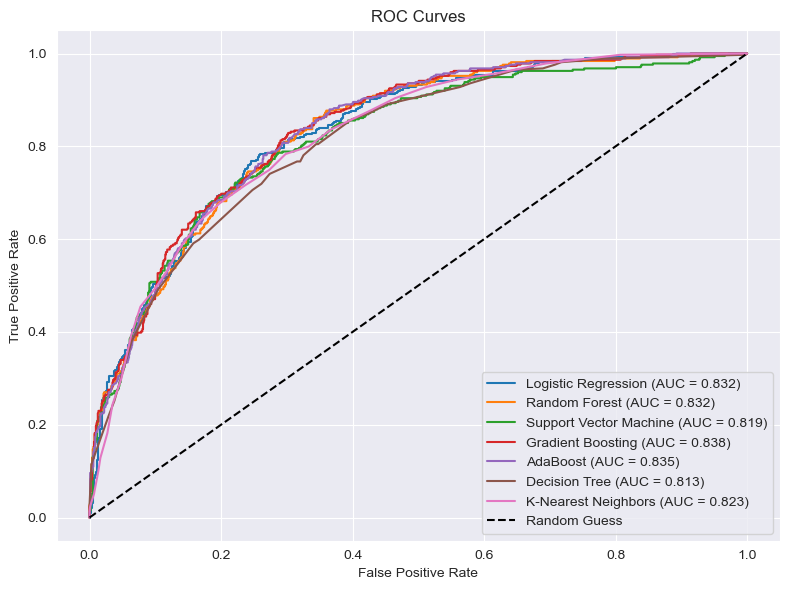

In [128]:
plot_roc_curves(trained_models, X_test, y_test)

### ROC Curve Analysis

The ROC (Receiver Operating Characteristic) curve below visualizes the performance of all trained classifiers by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various classification thresholds.

Each model's Area Under the Curve (AUC) score is a summary metric that reflects its ability to distinguish between the positive and negative classes:

- **AdaBoost (AUC = 0.836)** and **Gradient Boosting (AUC = 0.835)** achieved the highest AUC scores, indicating the strongest discriminatory power across threshold values.
- **Logistic Regression (AUC = 0.832)** and **Random Forest (AUC = 0.832)** follow closely, showing robust and consistent performance.
- **Support Vector Machine (AUC = 0.819)** also performed well, though slightly below the top models.
- **Decision Tree (AUC = 0.813)** showed moderate performance, while **K-Nearest Neighbors (AUC = 0.785)** had the lowest AUC among the models tested.
- The **dashed diagonal line** represents a random classifier (AUC = 0.5), and all models performed significantly above this baseline, confirming effective learning from the data.

### Conclusion

ROC analysis supports the earlier findings from other metrics: **AdaBoost** and **Gradient Boosting** are the top-performing models in terms of both accuracy and AUC. **Logistic Regression** provides a solid and interpretable baseline, especially valuable when model transparency is important.
